# ECCOv4 budgets
Evaluating budgets in the ECCOv4 model run using xgcm. Currently, calculations are done only for one face (here `face = 1`).

This notebook is based on the calculations and MATLAB code in evaluating_budgets_in_eccov4r3.pdf by Christopher G. Piecuch (ftp://ecco.jpl.nasa.gov/Version4/Release3/doc/evaluating_budgets_in_eccov4r3.pdf).

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from xmitgcm import open_mdsdataset
import xgcm

import matplotlib.pyplot as plt
%matplotlib inline

## Load datasets

**Note**: Model output is saved into files with 4 different prefixes depending on whether the variable is averaged (`ave`) or a snapshot (`snp`) and whether it is 2D or 3D. Reference date and time step are defined to get appropriate time points. For this example the ECCOv4r2 solution has been run only for the first year (1992).

In [2]:
ds_ave = open_mdsdataset('/rigel/ocp/users/jt2796/ECCO_v4_r2/run_budg3d_1yr/',
                         delta_t=3600, ref_date='1991-12-15 12:0:0', geometry='llc',
                         prefix=['monave2d','monave3d'])

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xmitgcm-0.2.1-py2.7.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [3]:
ds_snp = open_mdsdataset('/rigel/ocp/users/jt2796/ECCO_v4_r2/run_budg3d_1yr/',
                         delta_t=3600, ref_date='1992-1-1 12:0:0', geometry='llc',
                         prefix=['monsnp2d','monsnp3d'])

### Adjust time axis (optional)
**Note**: This code can be run to update the time axis to a certain common format. It is used here to be able to compare budget terms with other datasets (e.g., standard output from ECCOv4 netcdf files). Here, the time axis is defined for monthly averages to have time points always at the same day in the middle of the month (day=15).

In [4]:
ds_ave['time'] = pd.date_range(start='1992-01-15', periods=2*12, freq='SMS')[::2]

### Geothermal flux

In [5]:
geoflx = np.fromfile('/rigel/ocp/users/jt2796/ECCO_v4_r2/geothermalFlux.bin', dtype=np.float32)

**Note**: Geothermal flux dataset needs to be saved as an xarray data array with the same format as the model output. In order to reformat the loaded data array the byte-ordering needs to be changed.

In [6]:
# Data and type endianness don't match. Change data to match dtype and reshape to 1d
geoflx = geoflx.byteswap().reshape([105300,1])

In [7]:
# Reshape data for each face and save as xarray data array in LLC format
geoflx00 = xr.DataArray(geoflx[:8100,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx01 = xr.DataArray(geoflx[8100:16200,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx02 = xr.DataArray(geoflx[16200:24300,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx03 = xr.DataArray(geoflx[24300:32400,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx04 = xr.DataArray(geoflx[32400:40500,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx05 = xr.DataArray(geoflx[40500:48600,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx06 = xr.DataArray(geoflx[48600:56700,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])

geoflx0709 = geoflx[56700:81000,0].reshape([90,270])
geoflx07 = xr.DataArray(geoflx0709[:,:90],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx08 = xr.DataArray(geoflx0709[:,90:180],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx09 = xr.DataArray(geoflx0709[:,180:],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

geoflx1012 = geoflx[81000:,0].reshape([90,270])
geoflx10 = xr.DataArray(geoflx1012[:,:90],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx11 = xr.DataArray(geoflx1012[:,90:180],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx12 = xr.DataArray(geoflx1012[:,180:],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

In [8]:
geoflx_llc = xr.concat([geoflx00,geoflx01,geoflx02,geoflx03,geoflx04,geoflx05,geoflx06,
                        geoflx07,geoflx08,geoflx09,geoflx10,geoflx11,geoflx12], 'face')

**Note**: Geothermal flux needs to be a three dimensional field since the sources are distributed along the ocean floor at various depths. This requires a three dimensional mask (see below).

## Define terms
Before doing the budget calculations we need to define some terms that will be used in the budget calculations

### Number of seconds between each snapshot
**Note**: There are no snapshots for the first and last time point. Thus, we are skipping budget calculations for January and December 1992.

In [9]:
dt = ds_snp.time[1:].load()
# delta t in seconds. Note: devide by 10**9 to convert nanoseconds to seconds
dt.values = [float(t)/10**9 for t in np.diff(ds_snp.time)]

# time axis of dt should be the same as of the monthly averages
dt.time.values = ds_ave.time[1:-1].values

### Relevant constants

In [10]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

### Ocean depth

In [11]:
# Ocean depth (m)
Depth = ds_snp.sel(face=1).Depth.load()

### Grid dimensions
**Note**: Only use one face for testing

In [12]:
dxG = ds_ave.sel(face=1).dxG.load()
dyG = ds_ave.sel(face=1).dyG.load()

In [13]:
rA = ds_ave.sel(face=1).rA.load()
drF = ds_ave.sel(face=1).drF.load()
hFacC = ds_ave.sel(face=1).hFacC.load()

In [14]:
# Volume (m^3)
vol = (rA*drF*hFacC).transpose('k','j','i')

### Land mask 

In [15]:
# Make copy of hFacC
mskC = hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [16]:
# Make 2D land mask for surface (This is just for plotting/mapping purposes)
land_mask = mskC[0]
land_mask.values[land_mask.values==0] = np.nan

### Creating the grid object

In [17]:
grid = xgcm.Grid(ds_ave.sel(face=1), periodic=False)

## Evaluating the volume budget
$$G^{\eta,tot} = G^{\eta,conv} + G^{\eta,forc}$$
$$\frac{1}{H}\frac{\partial \eta}{\partial t} = -\nabla_{z^*}(s^*\,{\bf v}) - \frac{\partial w}{\partial z^*} + s^*\,F$$

### Total tendency
- ETAN: Surface Height Anomaly (m)

In [18]:
# Load snapshots for surface height anomaly from dataset (here: only one face is used)
ETANsnp = ds_snp.sel(face=1).ETAN.load()

In [19]:
# Total tendency (1/month)
tendV_perMonth = (xr.DataArray(50*[1],coords={'k': np.array(range(0,50))},dims=['k'])*\
                  (1/Depth)*(ETANsnp.shift(time=-1)-ETANsnp)).transpose('time','k','j','i')[:-1]

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xarray/core/variable.py:1165: RuntimeWarning: divide by zero encountered in divide
  else f(other_data, self_data))
/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in multiply
  if not reflexive


In [20]:
# Make sure time axis is the same as for the monthly variables
tendV_perMonth.time.values = ds_ave.time[1:-1].values

In [21]:
# Convert tendency from 1/month to 1/s
tendV_perSec = tendV_perMonth/dt

In [22]:
# Predefine tendV array with correct dimensions
tendV = xr.DataArray(np.nan*np.zeros([np.shape(tendV_perSec)[0]+2,50,90,90]),
                     coords={'time': range(np.shape(tendV_perSec)[0]+2),'k': np.array(range(0,50)),
                             'j': np.array(range(0,90)),'i': np.array(range(0,90))},dims=['time','k','j','i'])

# Time
tendV.time.values = ds_ave.time.values

# Add coordinates
tendV['XC'] = ds_snp.XC.sel(face=1)
tendV['YC'] = ds_snp.YC.sel(face=1)
tendV['Z'] = ds_snp.Z

In [23]:
# Total tendency (1/s)
tendV.values[1:-1] = tendV_perSec.values

### Forcing
- oceFWflx: net surface Fresh-Water flux into the ocean (kg/m^2/s)

In [24]:
# Load monthly averaged freshwater flux (here: only one face is used)
oceFWflx = ds_ave.sel(face=1).oceFWflx.load()

In [25]:
# Sea surface forcing on volume (1/s)
forcV = ((oceFWflx/rhoconst)/(hFacC*drF)).transpose('time','k','j','i')

# Make sure forcing term is zero below the surface
forcV.values[:,1:] = 0*forcV.values[:,1:]

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: divide by zero encountered in divide
  if not reflexive
/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in divide
  if not reflexive
/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


### Horizontal convergence
- UVELMASS: U Mass-Weighted Comp of Velocity (m/s)
- VVELMASS: V Mass-Weighted Comp of Velocity (m/s)

In [26]:
# Load monthly averaged velocities (here: only one face is used)
UVELMASS = ds_ave.sel(face=1).UVELMASS.load()
VVELMASS = ds_ave.sel(face=1).VVELMASS.load()

**Note**: Volume transports are calculated the same way as in the xgcm example (http://xgcm.readthedocs.io/en/latest/example_mitgcm.html#Divergence-Calculation). The only difference here is the omission of `hFacW` and `hFacS`. Including `hFacW` and `hFacS` in the calculation of the transport terms introduces unrealistic artifacts in the horizontal convergence near the ocean floor, which in turn causes the volume budget to be not balanced in the deeper ocean layers.

In [27]:
# Horizontal volume transports (m^3/s)
u_transport = UVELMASS * dyG * drF
v_transport = VVELMASS * dxG * drF

In [28]:
# Convergence of the horizontal flow (1/s)
hConvV = -(grid.diff(u_transport, 'X', boundary='extend') + \
           grid.diff(v_transport, 'Y', boundary='extend'))/vol

### Vertical convergence
- WVELMASS: Vertical Mass-Weighted Comp of Velocity (m/s)

In [29]:
# Load monthly averaged vertical velocity (here: only one face is used)
WVELMASS = ds_ave.sel(face=1).WVELMASS.load()

In [30]:
# Vertical volume transport (m^3/s)
w_transport = WVELMASS * rA

**Note**: Apparently, it is required to add the vertical volume flux at the air-sea interface (`oceFWflx`) to the surface layer to balance the budget.

In [31]:
# Add the vertical volume flux at the air-sea interface
w_transport[:,0] = w_transport[:,0]+(forcV*vol)[:,0]

In [32]:
# Convergence of the vertical flow (m^3/s)
vConvV = grid.diff(w_transport, 'Z', boundary='extend')

**Note**: Convergence in the deepest depth layer in `vConvV` needs to be replaced by minus the vertical volume flux. Otherwise, the volume budget in the deepest layer will be unbalanced. This is probably an issue with the given way `grid.diff()` calculates values at the edges.

In [33]:
vConvV[:,-1,:,:] = -w_transport[:,-1,:,:]

In [34]:
# Convergence of the vertical flow (1/s)
vConvV = vConvV/vol

### Total convergence

In [35]:
ConvV = hConvV+vConvV

### Total tendency

In [36]:
totalV = ConvV + forcV

### Map accumulated residual in volume budget 

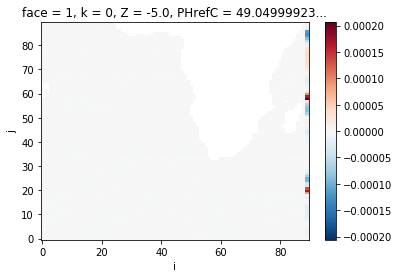

In [37]:
((totalV-tendV).sum(dim='k').sum(dim='time')*land_mask).plot(cmap='RdBu_r')

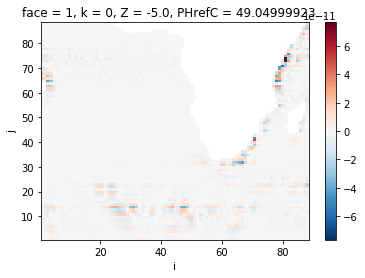

In [38]:
# Ignoring face boundaries
((totalV-tendV).sum(dim='k').sum(dim='time')*land_mask)[1:89,1:89].plot(cmap='RdBu_r')

**Note**: The residuals are larger when doing the calculations on Unix (on Habanero) compared to Mac OS. When running the code on Unix, there is some bias in the horizontal convergence term (`hConvV`), but it is very small.

### Time series for an arbitrarily chosen grid point

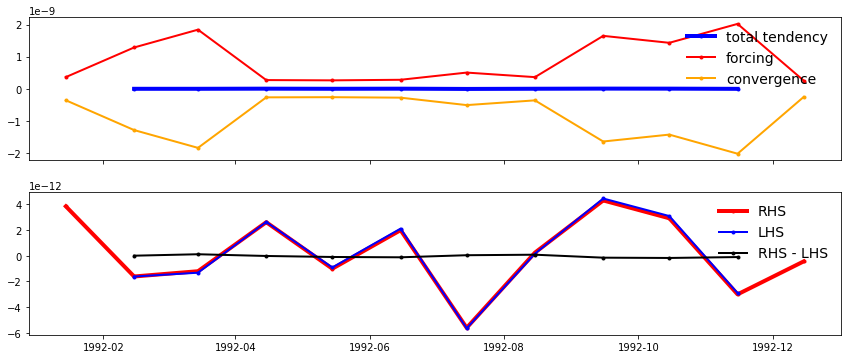

In [39]:
k = 0
j = 10
i = 10

f, axes = plt.subplots(2, 1,figsize=(12,5))
f.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(tendV.time, tendV[:,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcV.time, forcV[:,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(ConvV.time, ConvV[:,k,j,i], lw=2, color='orange', marker='.',label='convergence')
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(loc='upper right',frameon=False,fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(totalV.time, totalV[:,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendV.time, tendV[:,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendV.time, totalV[:,k,j,i]-tendV[:,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.legend(loc='upper right',frameon=False,fontsize=14)

plt.show()

### Verical profiles for an arbitrarily chosen grid point

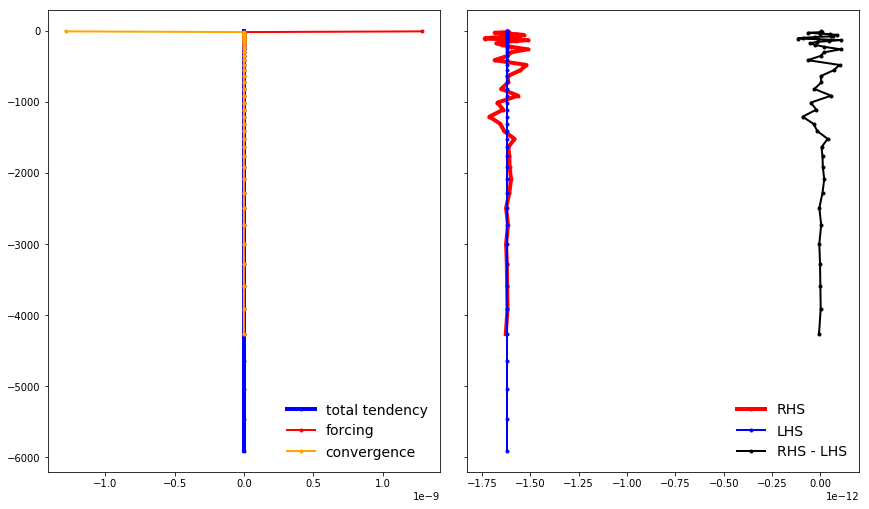

In [40]:
t = 1
j = 10
i = 10

f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
f.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendV[t,:,j,i],tendV.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcV[t,:,j,i],forcV.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(ConvV[t,:,j,i],ConvV.Z, lw=2, color='orange', marker='.',label='convergence')
plt.legend(loc='lower right',frameon=False,fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(totalV[t,:,j,i],totalV.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendV[t,:,j,i],tendV.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalV[t,:,j,i]-tendV[t,:,j,i],totalV.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower right',frameon=False,fontsize=14)

plt.show()

## Evaluating the heat budget
$$G^{\theta,tot} = G^{\theta,adv} + G^{\theta,forc} + G^{\theta,diff}$$
$$\frac{\partial(s^*\theta)}{\partial t} = -\nabla_{z^*}(s^*\,\theta\,{\bf v_{res}}) - \frac{\partial(\theta\,w_{res})}{\partial z^*} + s^*\,F_{\theta} + s^*\,D_{\theta}$$

### Total tendency
- THETA: Potential Temperature (degC)

In [41]:
# Load snapshots of theta (here only one face is used)
THETAsnp = ds_snp.sel(face=1).THETA.load()

In [42]:
# Calculate the s∗theta term
HCsnp = THETAsnp*(1+ETANsnp/Depth)

In [43]:
# Total tendency (degC/month)
tendH_perMonth = (HCsnp.shift(time=-1)-HCsnp)[:-1]

In [44]:
# Make sure time axis is the same as for the monthly variables
tendH_perMonth.time.values = ds_ave.time[1:-1].values

In [45]:
# Convert tendency from 1/month to 1/s
tendH_perSec = tendH_perMonth/dt

In [46]:
# Predefine tendH array with correct dimensions
tendH = xr.DataArray(np.nan*np.zeros([np.shape(tendH_perSec)[0]+2,50,90,90]),
                     coords={'time': range(np.shape(tendH_perSec)[0]+2),'k': np.array(range(0,50)),
                             'j': np.array(range(0,90)),'i': np.array(range(0,90))},dims=['time','k','j','i'])

# Time
tendH.time.values = ds_ave.time.values

# Add coordinates
tendH['XC'] = ds_snp.XC.sel(face=1)
tendH['YC'] = ds_snp.YC.sel(face=1)
tendH['Z'] = ds_snp.Z

In [47]:
# Total tendency (degC/s)
tendH.values[1:-1] = tendH_perSec.values

### Forcing
- TFLUX: total heat flux (match heat-content variations) (W/m^2)
- oceQsw: net Short-Wave radiation (+=down) (W/m^2)

In [48]:
# Load monthly averages of heat flux and shortwave radiation (here only one face is used)
TFLUX = ds_ave.sel(face=1).TFLUX.load()
oceQsw = ds_ave.sel(face=1).oceQsw.load()

#### Defining terms needed for evaluating surface heat forcing

In [49]:
Z = ds_ave.sel(face=1).Z.load()
RF = np.concatenate([ds_ave.sel(face=1).Zp1.values[:-1],[np.nan]])

**Note**: `Z` and `Zp1` are used in deriving surface heat penetration. MATLAB code uses `RF` from `mygrid` structure.

In [50]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [51]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [52]:
# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating flux

In [53]:
# Surface heat flux (below the surface)
forcH = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','k','j','i')

# Reset surface layer to zero
forcH.values[:,0] = 0*forcH.values[:,0]

In [54]:
# Surface heat flux (at the sea surface)
forcH[:,0] = ((TFLUX - (1-(q1[0]-q2[0]))*oceQsw)*mskC[0]).transpose('time','j','i')

#### Add geothermal heat flux

In [55]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)
mskC_shifted.values[-1,:,:] = 0
mskb = mskC - mskC_shifted

In [56]:
# Create 3d field of geothermal heat flux
geoflx2d = geoflx_llc.sel(face=1)
geoflx3d = geoflx2d * mskb
GEOFLX = geoflx3d.transpose('k','j','i')

In [57]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
forcH = ((forcH + GEOFLX)/(rhoconst*c_p))/(hFacC*drF)

### Advection
#### Horizontal convergence
- ADVx_TH: U Comp. Advective Flux of Pot.Temperature (degC m^3/s)
- ADVy_TH: V Comp. Advective Flux of Pot.Temperature (degC m^3/s)

In [58]:
# Load monthly averaged advective fluxes (here only one face is used)
ADVx_TH = ds_ave.sel(face=1).ADVx_TH.load()
ADVy_TH = ds_ave.sel(face=1).ADVy_TH.load()

In [59]:
# Convergence of horizontal advection (degC/s)
adv_hConvH = -(grid.diff(ADVx_TH, 'X', boundary='extend') + \
               grid.diff(ADVy_TH, 'Y', boundary='extend'))/vol

#### Vertical convergence
- ADVr_TH: Vertical Advective Flux of Pot.Temperature (degC m^3/s)

In [60]:
# Load monthly averages of vertical advective flux (here only one face is used)
ADVr_TH = ds_ave.sel(face=1).ADVr_TH.load()

**Note**: The heat budget only balances when the sea surface forcing is not added to the vertical advective flux (at the air-sea interface). This is different from the volume and salinity budget.

In [61]:
# Convergence of the vertical advection (degC m^3/s)
adv_vConvH = grid.diff(ADVr_TH, 'Z', boundary='extend')

**Note**: Convergence in the deepest layer in `adv_vConvH` needs to be replaced by minus the vertical advective flux. Otherwise, the volume budget in the deepest layer will be unbalanced. This is probably an issue with the given way `grid.diff()` calculates values at the edges.

In [62]:
adv_vConvH[:,-1,:,:] = -ADVr_TH[:,-1,:,:]

In [63]:
# Convergence of vertical advection (degC/s)
adv_vConvH = adv_vConvH/vol

### Diffusion
#### Horizontal convergence
- DFxE_TH: U Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)
- DFyE_TH: V Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)

In [64]:
# Load monthly averages of diffusive fluxes (here only one face is used)
DFxE_TH = ds_ave.sel(face=1).DFxE_TH.load()
DFyE_TH = ds_ave.sel(face=1).DFyE_TH.load()

In [65]:
# Convergence of horizontal diffusion (degC/s)
dif_hConvH = -(grid.diff(DFxE_TH, 'X', boundary='extend') + \
               grid.diff(DFyE_TH, 'Y', boundary='extend'))/vol

#### Vertical convergence
- DFrE_TH: Vertical Diffusive Flux of Pot.Temperature (Explicit part) (degC m^3/s)
- DFrI_TH: Vertical Diffusive Flux of Pot.Temperature (Implicit part) (degC m^3/s)

In [66]:
# Load monthly averages of vertical diffusive fluxes (here only one face is used)
DFrE_TH = ds_ave.sel(face=1).DFrE_TH.load()
DFrI_TH = ds_ave.sel(face=1).DFrI_TH.load()

In [67]:
# Convergence of vertical diffusion (degC m^3/s)
dif_vConvH = grid.diff(DFrE_TH, 'Z', boundary='extend') + grid.diff(DFrI_TH, 'Z', boundary='extend')

**Note**: Convergence in the deepest layer in `dif_vConvH` needs to be replaced by minus the vertical diffusive flux to balance the budget.

In [68]:
dif_vConvH[:,-1,:,:] = -(DFrE_TH+DFrI_TH)[:,-1,:,:]

In [69]:
# Convergence of vertical diffusion (degC/s)
dif_vConvH = dif_vConvH/vol

### Total convergences

In [70]:
# Total convergence of advective flux
adv_ConvH = adv_hConvH + adv_vConvH

# Total convergence of diffusive flux
dif_ConvH = dif_hConvH + dif_vConvH

# Total convergence
ConvH = adv_ConvH + dif_ConvH

### Total tendency

In [71]:
totalH = ConvH + forcH

### Map accumulated residual in volume budget 

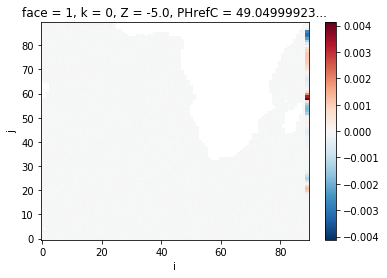

In [72]:
((totalH-tendH).sum(dim='k').sum(dim='time')*land_mask).plot(cmap='RdBu_r')

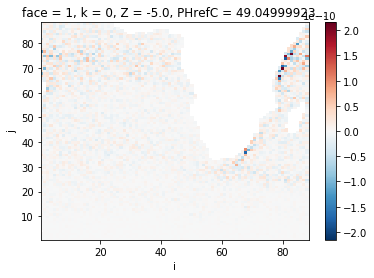

In [73]:
# Ignoring face boundaries
((totalH-tendH).sum(dim='k').sum(dim='time')*land_mask)[1:89,1:89].plot(cmap='RdBu_r')

### Time series for an arbitrarily chosen grid point

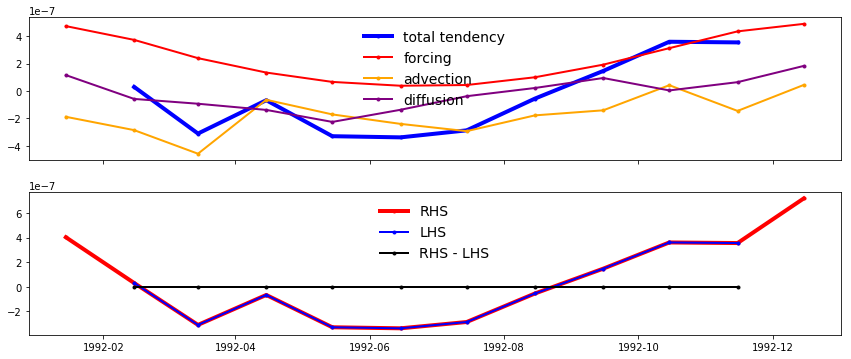

In [74]:
k = 1
j = 10
i = 10

f, axes = plt.subplots(2, 1,figsize=(12,5))
f.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(tendH.time, tendH[:,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH.time, forcH[:,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH.time, adv_ConvH[:,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH.time, dif_ConvH[:,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(loc='upper center',frameon=False,fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(totalH.time, totalH[:,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH.time, tendH[:,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendH.time, totalH[:,k,j,i]-tendH[:,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.legend(loc='upper center',frameon=False,fontsize=14)

plt.show()

### Verical profiles for an arbitrarily chosen grid point

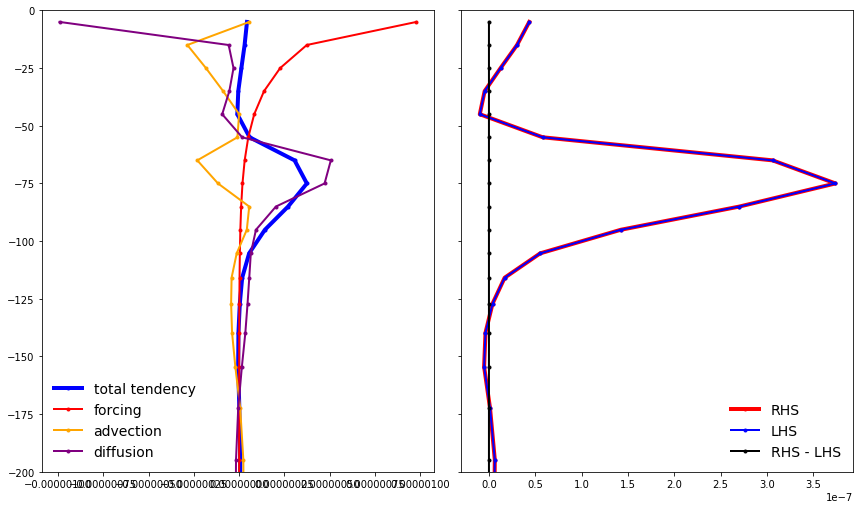

In [75]:
t = 1
j = 10
i = 10

f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
f.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendH[t,:,j,i],tendH.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH[t,:,j,i],forcH.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH[t,:,j,i],adv_ConvH.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH[t,:,j,i],dif_ConvH.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.subplot(1, 2, 2)
plt.plot(totalH[t,:,j,i],totalH.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH[t,:,j,i],tendH.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalH[t,:,j,i]-tendH[t,:,j,i],tendH.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower right',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.show()

## Evaluating the salt budget
$$G^{S,tot} = G^{S,adv} + G^{S,forc} + G^{S,diff}$$
$$\frac{\partial(s^*S)}{\partial t} = -\nabla_{z^*}(s^*\,S\,{\bf v_{res}}) - \frac{\partial(S\,w_{res})}{\partial z^*} + s^*\,F_S + s^*\,D_S$$

### Total tendency
- SALT: Salinity (psu)

In [76]:
# Load salinity snapshot (here only one face is used)
SALTsnp = ds_snp.sel(face=1).SALT.load()

In [77]:
# Calculate s*S term
sSALT = SALTsnp*(1+ETANsnp/Depth)

In [78]:
# Total tendency (psu/month)
tendS_perMonth = (sSALT.shift(time=-1)-sSALT)[:-1]x

In [79]:
# Make sure time axis is the same as for the monthly variables
tendS_perMonth.time.values = ds_ave.time[1:-1].values

In [80]:
# Convert tendency from 1/month to 1/s
tendS_perSec = tendS_perMonth/dt

In [81]:
# Predefine tendS array with correct dimensions
tendS = xr.DataArray(np.nan*np.zeros([np.shape(tendS_perSec)[0]+2,50,90,90]),
                     coords={'time': range(np.shape(tendS_perSec)[0]+2),'k': np.array(range(0,50)),
                             'j': np.array(range(0,90)),'i': np.array(range(0,90))},dims=['time','k','j','i'])

# Time
tendS.time.values = ds_ave.time.values

# Add coordinates
tendS['XC'] = ds_snp.XC.sel(face=1)
tendS['YC'] = ds_snp.YC.sel(face=1)
tendS['Z'] = ds_snp.Z

In [82]:
# Total tendency (psu/s)
tendS.values[1:-1] = tendS_perSec.values

### Forcing
- SFLUX: total salt flux (match salt-content variations) (g/m^2/s)
- oceSPtnd: salt tendency due to salt plume flux (g/m^2/s)

In [83]:
# Load monthly averaged SFLUX and oceSPtnd (here only one face is used)
SFLUX = ds_ave.sel(face=1).SFLUX.load()
oceSPtnd = ds_ave.sel(face=1).oceSPtnd.load()

In [84]:
# Expand SFLUX along depth axis
SFLUX3d = xr.concat(50*[SFLUX.expand_dims('k',1)],dim='k')
SFLUX3d.coords['k'] = SFLUX3d.k

# Reset SFLUX3d to zero below surface layer
SFLUX3d.values[:,1:] = 0*SFLUX3d[:,1:].values

**Note**: `SFLUX` and `oceSPtnd` is given in g/m^2/s. Dividing by density and corresponding vertical length scale (`drF`) results in g/kg/s, which is the same as psu/s.

In [85]:
# Surface salt flux (psu/s)
forcS = (((SFLUX3d+oceSPtnd)/rhoconst)/(hFacC*drF)).transpose('time','k','j','i')

### Advection
#### Horizontal convergence
- ADVx_SLT: U Comp. Advective Flux of Salinity (psu m^3/s)
- ADVy_SLT: V Comp. Advective Flux of Salinity (psu m^3/s)

In [86]:
# Load monthly averaged advective fluxes (here only one face is used)
ADVx_SLT = ds_ave.sel(face=1).ADVx_SLT.load()
ADVy_SLT = ds_ave.sel(face=1).ADVy_SLT.load()

In [87]:
# Convergence of horizontal advection (psu/s)
adv_hConvS = -(grid.diff(ADVx_SLT, 'X', boundary='extend') + \
               grid.diff(ADVy_SLT, 'Y', boundary='extend'))/vol

#### Vertical convergence
- ADVr_SLT: Vertical Advective Flux of Salinity (psu m^3/s)

In [88]:
# Load monthly averaged vertical advective flux (here only one face is used)
ADVr_SLT = ds_ave.sel(face=1).ADVr_SLT.load()

**Note**: The salt budget only balances when the sea surface forcing is not added to the vertical salt flux (at the air-sea interface). This is different from the volume and salinity budget.

In [89]:
# Convergence of vertical advection (psu m^3/s)
adv_vConvS = grid.diff(ADVr_SLT, 'Z', boundary='extend')

**Note**: The deepest depth layer in `adv_vConvS` needs to be replaced by  minus the vertical advective flux. This is probably an issue with how `grid.diff()` calculates the edges.

In [90]:
adv_vConvS[:,-1,:,:] = -ADVr_SLT[:,-1,:,:]

In [91]:
# Convergence of vertical advection (psu/s)
adv_vConvS = adv_vConvS/vol

### Diffusion
#### Horizontal convergence
- DFxE_SLT: U Comp. Diffusive Flux of Salinity (psu m^3/s)
- DFyE_SLT: V Comp. Diffusive Flux of Salinity (psu m^3/s)

In [92]:
# Load monthly averaged horizontal diffusive fluxes (here only one face is used)
DFxE_SLT = ds_ave.sel(face=1).DFxE_SLT.load()
DFyE_SLT = ds_ave.sel(face=1).DFyE_SLT.load()

In [93]:
# Convergence of horizontal diffusion (psu/s)
dif_hConvS = -(grid.diff(DFxE_SLT, 'X', boundary='extend') + \
               grid.diff(DFyE_SLT, 'Y', boundary='extend'))/vol

#### Vertical convergence
- DFrE_SLT: Vertical Diffusive Flux of Salinity (Explicit part) (psu m^3/s)
- DFrI_SLT: Vertical Diffusive Flux of Salinity (Implicit part) (psu m^3/s)

In [94]:
# Load monthly averaged vertical diffusive fluxes (here only one face is used)
DFrE_SLT = ds_ave.sel(face=1).DFrE_SLT.load()
DFrI_SLT = ds_ave.sel(face=1).DFrI_SLT.load()

In [95]:
# Convergence of vertical diffusion (psu m^3/s)
dif_vConvS = grid.diff(DFrE_SLT, 'Z', boundary='extend') + grid.diff(DFrI_SLT, 'Z', boundary='extend')

**Note**: The deepest depth layer in `dif_vConvS` needs to be calculated seperately. This is probably an issue with the given boundary condition in `grid.diff()`.

In [96]:
# Convergence of vertical diffusion (psu/s)
dif_vConvS = dif_vConvS/vol

### Total convergences

In [97]:
# Total convergence of advective flux
adv_ConvS = adv_hConvS + adv_vConvS

# Total convergence of diffusive flux
dif_ConvS = dif_hConvS + dif_vConvS

# Total convergence
ConvS = adv_ConvS + dif_ConvS

### Total tendency

In [98]:
totalS = ConvS + forcS

### Plot accumulated residual in salt budget 

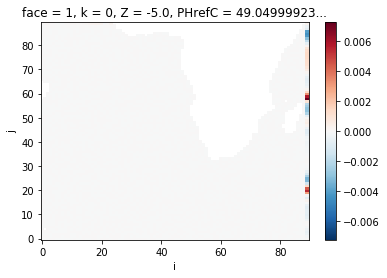

In [99]:
((totalS-tendS).sum(dim='k').sum(dim='time')*land_mask).plot(cmap='RdBu_r')#,vmin=-5e-10,vmax=5e-10)

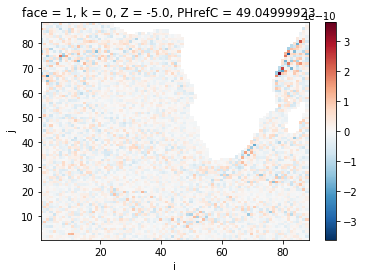

In [100]:
# Ignoring face boundaries
((totalS-tendS).sum(dim='k').sum(dim='time')*land_mask)[1:89,1:89].plot(cmap='RdBu_r')

### Time series for an arbitrarily chosen grid point

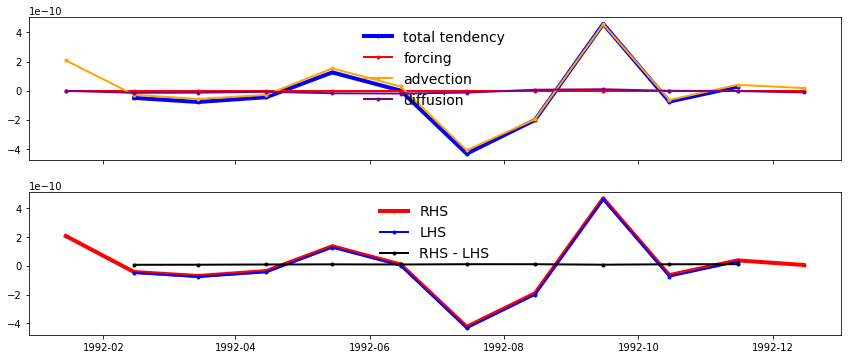

In [101]:
k = -1
j = 3
i = 11

f, axes = plt.subplots(2, 1,figsize=(12,5))
f.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(tendS.time, tendS[:,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcS.time, forcS[:,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvS.time, adv_ConvS[:,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvS.time, dif_ConvS[:,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(loc='upper center',frameon=False,fontsize=14)

plt.subplot(2, 1, 2)
#plt.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
plt.plot(totalS.time, totalS[:,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendS.time, tendS[:,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendS.time, totalS[:,k,j,i]-tendS[:,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.legend(loc='upper center',frameon=False,fontsize=14)

plt.show()

### Verical profiles for an arbitrarily chosen grid point

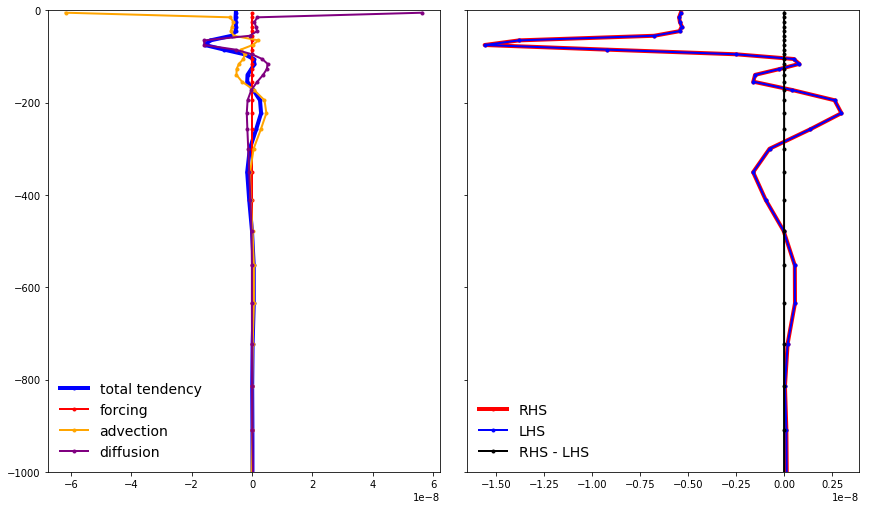

In [102]:
t = 1
j = 10
i = 10

f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
f.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendS[t,:,j,i], tendS.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcS[t,:,j,i], forcS.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvS[t,:,j,i], adv_ConvS.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvS[t,:,j,i], dif_ConvS.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower left', frameon=False, fontsize=14)
plt.ylim([-1000,0])
#plt.xlim([-2e-10,2e-10])

plt.subplot(1, 2, 2)
plt.axvline(x=0, ymin=0, ymax=1, linewidth=0.5, color = 'k')
plt.plot(totalS[t,:,j,i], totalS.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendS[t,:,j,i], tendS.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalS[t,:,j,i]-tendS[t,:,j,i], tendS.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-1000,0])
#plt.xlim([-2e-10,2e-10])

plt.show()

## Evaluating the salinity budget
$$G^{Sln,tot} = G^{Sln,adv} + G^{Sln,forc} + G^{Sln,diff}$$
$$\frac{\partial S}{\partial t} = \frac{1}{s^*} \left[S\,\nabla_{z^*}(s^*\,{\bf v}) + S\,\frac{\partial w}{\partial z^*} - \nabla_{z^*}(s^*\,S\,{\bf v_{res}}) - \frac{\partial S\,w_{res}}{\partial z^*}\right] + D_S + F_S - S\,F$$

### Scale factor
- Depth: Ocean_depth (m)
- ETAN: Surface Height Anomaly (m)

In [103]:
# Load monthly averaged surface height anomaly (here only one face is used)
ETAN = ds_ave.sel(face=1).ETAN.load()

In [104]:
# Scale factor
rstarfac = ((Depth + ETAN)/Depth).transpose('time','j','i')

### Total tendency

In [105]:
# Total tendency (psu/month)
tendSln_perMonth = (SALTsnp.shift(time=-1)-SALTsnp)[:-1]

In [106]:
# Make sure time axis is the same as for the monthly variables
tendSln_perMonth.time.values = ds_ave.time[1:-1].values

In [107]:
# Total tendency (psu/s)
tendSln_perSec = tendSln_perMonth/dt

In [108]:
# Predefine tendSln array with correct dimensions
tendSln = xr.DataArray(np.nan*np.zeros([np.shape(tendSln_perSec)[0]+2,50,90,90]),
                       coords={'time': range(np.shape(tendSln_perSec)[0]+2),'k': np.array(range(0,50)),
                               'j': np.array(range(0,90)),'i': np.array(range(0,90))},dims=['time','k','j','i'])

# Time
tendSln.time.values = ds_ave.time.values

# Add coordinates
tendSln['XC'] = ds_snp.XC.sel(face=1)
tendSln['YC'] = ds_snp.YC.sel(face=1)
tendSln['Z'] = ds_snp.Z

In [109]:
# Total tendency (psu/s)
tendSln.values[1:-1] = tendSln_perSec.values

### Forcing
**Note**: The forcing term is comprised of both salt flux (`forcS`) and volume (i.e., freshwater) flux (`forcV`).
- SALT: Salinity (psu)

In [110]:
# Load monthly averaged salinity fields (here only one face is used)
SALT = ds_ave.sel(face=1).SALT.load()

In [111]:
# Sea surface forcing for salinity (psu/s)
forcSln = (-SALT*forcV + forcS)/rstarfac

### Advection
#### Horizontal convergence

In [112]:
adv_hConvSln = (-SALT*hConvV + adv_hConvS)/rstarfac

#### Vertical convergence

In [113]:
adv_vConvSln = (-SALT*vConvV + adv_vConvS)/rstarfac

### Diffusion
#### Horizontal convergence

In [114]:
dif_hConvSln = dif_hConvS/rstarfac

#### Vertical convergence

In [115]:
dif_vConvSln = dif_vConvS/rstarfac

### Total convergences

In [116]:
# Total convergence of advective flux
adv_ConvSln = adv_hConvSln + adv_vConvSln

# Total convergence of diffusive flux
dif_ConvSln = dif_hConvSln + dif_vConvSln

# Total convergence
ConvSln = adv_ConvSln + dif_ConvSln

### Total tendency

In [117]:
totalSln = ConvSln + forcSln

### Plot Accumulated residual in salinity budget 

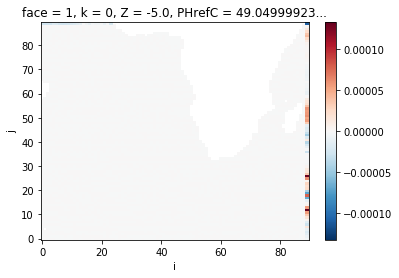

In [118]:
((totalSln-tendSln).sum(dim='k').sum(dim='time')*land_mask).plot(cmap='RdBu_r')

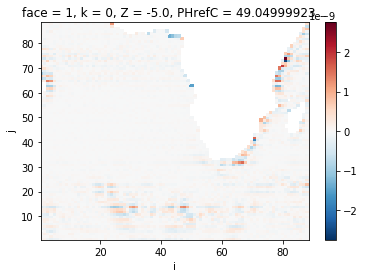

In [119]:
# Ignoring face boundaries
((totalSln-tendSln).sum(dim='k').sum(dim='time')*land_mask)[1:89,1:89].plot(cmap='RdBu_r')

### Time series for an arbitrarily chosen grid point

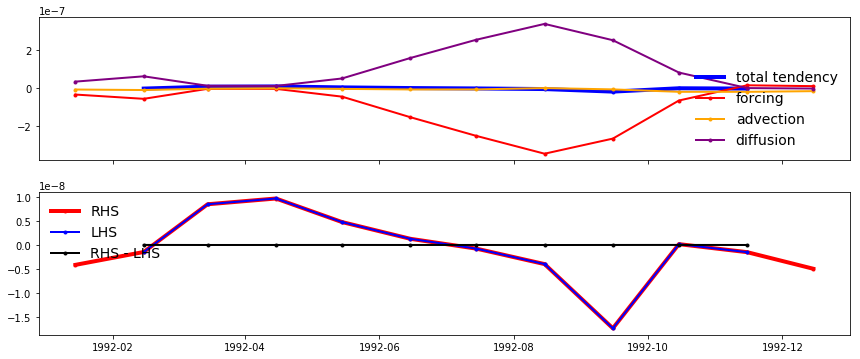

In [120]:
k = 0
j = 0
i = 10

f, axes = plt.subplots(2, 1,figsize=(12,5))
f.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(tendSln.time, tendSln[:,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcSln.time, forcSln[:,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvSln.time, adv_ConvSln[:,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvSln.time, dif_ConvSln[:,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(loc='lower right',frameon=False,fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(totalSln.time, totalSln[:,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendSln.time, tendSln[:,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendSln.time, totalSln[:,k,j,i]-tendSln[:,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.legend(loc='upper left',frameon=False,fontsize=14)

plt.show()

### Verical profiles for an arbitrarily chosen grid point

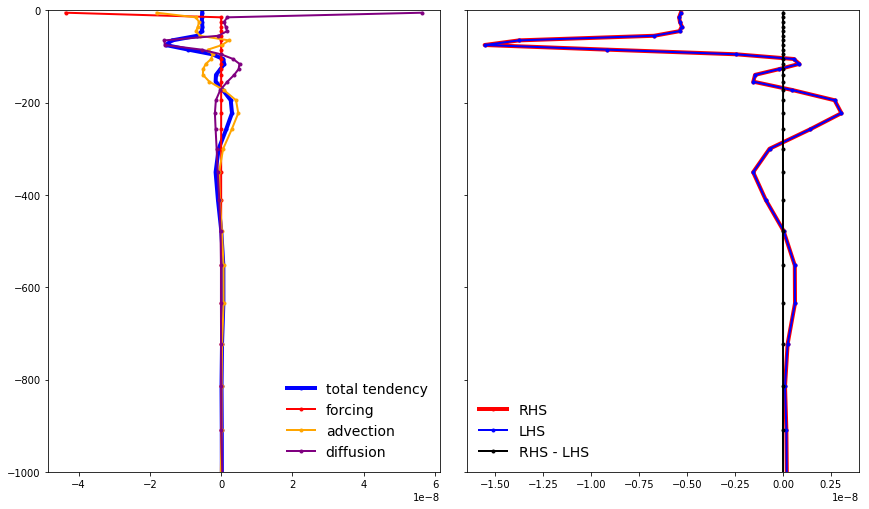

In [121]:
t = 1
j = 10
i = 10

f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
f.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendSln[t,:,j,i],tendSln.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcSln[t,:,j,i],forcSln.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvSln[t,:,j,i],adv_ConvSln.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvSln[t,:,j,i],dif_ConvSln.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower right',frameon=False,fontsize=14)
plt.ylim([-1000,0])

plt.subplot(1, 2, 2)
plt.axvline(x=0, ymin=0, ymax=1, linewidth=0.5, color = 'k')
plt.plot(totalSln[t,:,j,i],totalSln.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendSln[t,:,j,i],tendSln.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalSln[t,:,j,i]-tendSln[t,:,j,i],tendSln.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-1000,0])

plt.show()